<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/S5_Normalization_Regularization/S5_Assignment_Running_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Session 5: 
- Leverage code from session 4 and modularize training code to generate a model.py
- Call model.py (separate py file created that takes input of the normalization technique and is imported as a module)
- train the model for 20 epochs
- produce accuracy/loss comparison charts for each experiment 


In [1]:
 # import packages and modules
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [237]:
from google.colab import files 
files.upload()

Saving model.py to model.py


{'model.py': b'# -*- coding: utf-8 -*-\n"""model_py_testing_notebook.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1LKejf6oBur7w0Aont_gx6KTLdrPjRDF9\n\n## Convolution Model Template\n- Define Model object\n- Define Training module\n- Parameterization to select normalization types\n"""\n\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.optim as optim\nfrom torchvision import datasets, transforms\nimport torchvision\nfrom matplotlib import pyplot as plt\nimport numpy as np\n\ndef norm_fn(out_channels, norm_type = "BN", group = 4):\n  \'\'\' \n  Returns the normalization to be used based on user inputs.\n  User allowed to provide one of 3 inputs: BN | LN | GN for batch layer and group normalization repsectively.\n  Specifying groups is only relevant for group_normalization\n  \'\'\'\n  if norm_type == "BN":\n    return nn.BatchNorm2d(out_channels)\n  elif norm_type == "LN":\n

In [238]:
import model as model_py


### Self Learning section to understand the DataLoader utility and transforms

In [ ]:
# getting the data t find mean and sddev
data_full = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True))

In [ ]:
type(data_full.dataset.targets)

torch.Tensor

In [ ]:
data_full.dataset.targets.unique(return_counts=True) #get counts per distinct level


(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [ ]:
len(data_full.dataset.targets.unique(return_counts=False)) #get distinct levels

10

In [ ]:
# data_full.dataset.data.mean() # would not work! as the data type is utf8 gives byte
data_full.dataset.data.float().mean() # workaround 1
(data_full.dataset.data * 1.0).mean(2) # workaround 2

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 18.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [ ]:
# setup the transformations
# train
train_transforms = transforms.Compose([
    # transforms.RandomRotation((-10.0,10.0), fill=(1.,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)) # mean and stdev of training_data (??)
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
# Dataset split into train and test
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
# Checking GPU support and setting seed.
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_dat = train.train_data
train_dat = train.transform(train_dat.numpy())

In [ ]:
train_dat[1,] # Scaling of the data oes 

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


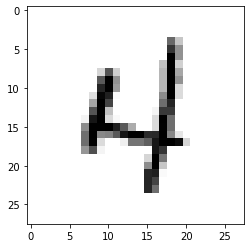

In [ ]:
# Understanding the data summaries and samples
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [ ]:
train_dat[1]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(255.)
 - mean: tensor(33.3184)
 - std: tensor(78.5675)
 - var: tensor(6172.8506)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 1, 28, 28])
torch.Size([128])


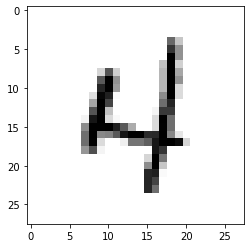

In [ ]:
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_dat.float()))
print(' - max:', torch.max(train_data.float()))
print(' - mean:', torch.mean(train_data.float()))
print(' - std:', torch.std(train_data.float()))
print(' - var:', torch.var(train_data.float()))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


### Loading and Transforming the data as per assignment 4

In [94]:
# Defining transformations
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0,7.0), fill=(0)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # The mean and stdev represent that of the training data. 
    # transforms.ConvertImageDtype(torch.float)
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [95]:
# Calling Dataloaders
# Dataset split into train and test
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)# Checking GPU support and setting seed.
# Checking GPU support and setting seed.
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
## NEED TO UNDERSTAND HOW TO RUN THIS CELL AFTER A RANDOMROTATION IS DONE IN THE BEGINNING
# Understanding the data summaries and samples
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy()) 
# !!! The above line errors out !!!  

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

test_data = test.test_data
test_data = test.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.test_data.cpu().numpy().shape)
print(' - Tensor Shape:', test.test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


TypeError: ignored

### Defining the original model (leveraging model.py)

In [7]:
# Taking the CNN model from the imported model.py module 

In [8]:
# Model params and network summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
bn_model = model_py.NNet(dropout_val = 0.05, norm_type = 'BN').to(device)
summary(bn_model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
      BatchNorm2d-11            [-1, 8, 24, 24]              16
          Dropout-12            [-1, 8, 24, 24]               0

In [221]:
# Training and testing modules
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def training_f(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def testing_f(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [222]:
def training_L1_f(model, device, train_loader, optimizer, epoch, l1_lambda=0.001): 
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss (updated to include l1_norm!)
    loss = F.nll_loss(y_pred, target) # prediction loss
    train_losses.append(loss) # keeping the train_losses with only the prediction_loss
    l1_norm = sum(p.abs().sum() for p in model.parameters()) # absolute sum of all parameters
    loss_t = loss + l1_lambda*l1_norm # added l1_norm to prediction_loss

    # Backpropagation
    loss_t.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


In [223]:
def model_eval_f(model, device, test_loader):
  '''
  - provides accuracy and loss for the dataset created via test_loader
  - provides a crosstab of all mispredictions to identify where model commonly fails
  - takes the first 10 mispredictions and plots them on a 5X2 grid
  '''

  model.eval()
  test_loss = 0
  correct = 0
  preds = []
  targets = []
  incorrect_pred_targets = []
  incorrect_preds = []
  incorrect_pred_images = []
  incorrect_pred_images_all = []

  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          incorrects = ~pred.eq(target.view_as(pred))
          if len(target[incorrects.squeeze(dim=1)])>0:
            incorrect_pred_targets.append(target[incorrects.squeeze(dim=1)])
            incorrect_preds.append(pred[incorrects.squeeze(dim=1)])
            incorrect_pred_images.append(data[incorrects.squeeze(dim=1)])
  incorrect_pred_targets_all = [t.cpu().numpy() for t in incorrect_pred_targets]
  incorrect_pred_targets_all = [element for sublist in incorrect_pred_targets_all for element in sublist]
  incorrect_preds_all = [t.cpu().numpy() for t in incorrect_preds]
  incorrect_preds_all = [element for sublist in incorrect_preds_all for element in sublist]
  incorrect_preds_all = [element for sublist in incorrect_preds_all for element in sublist]
  incorrect_pred_images_all = [element for sublist in incorrect_pred_images for element in sublist]
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

  test_acc.append(100. * correct / len(test_loader.dataset))
  figure = plt.figure(figsize = (10,12))
  num_of_images = 10
  for index in range(1, num_of_images + 1):
      plt.subplot(5, 2, index)
      plt.axis('off')
      plt.imshow(incorrect_pred_images_all[index].cpu().numpy().squeeze(), cmap='gray_r')
      plt.title(f'Target- {incorrect_pred_targets_all[index]} ; Predicted- {incorrect_preds_all[index]}')

  print("crosstab of incorrect prediction to understand patterns: ")
  return pd.crosstab(pd.Series(incorrect_pred_targets_all, name='Actual'), pd.Series(incorrect_preds_all, name='Predicted'))


In [253]:
def model_viz(metrics_m1, metrics_m2, metrics_m3, train_val = ["training","validation"], metric = ["loss","accuracy"]):
  """
  Visualization of 3 models and their 4 sets of metrics (train/validation X loss/accuracy)
  Each metrics_mi is a list expected in the order of [train_loss,validation_loss, train_accuracy, validation_accuracy]
  Setting up for 3 models but can be generalized for a single metrics_m1 tensor or 3-d matrix for multiple models
  """

  fig, axs = plt.subplots(2,2, figsize = (18,10))
  cnt=0
  for i in np.arange(0,2): # represents loss/accuracy
    for j in np.arange(0,2): # represents train/validation
      axs[i,j].plot(metrics_m1[cnt])
      axs[i,j].plot(metrics_m2[cnt])
      axs[i,j].plot(metrics_m3[cnt])
      axs[i,j].set_xlabel('# epochs')
      axs[i,j].set_ylabel(f"{train_val[j]} {metric[i]}")
      axs[i,j].legend(['Model with GN', 'model with LN','model with L1+BN'], loc = 'upper right')  
      axs[i,j].set_title(f"{train_val[j]} {metric[i]} across the 3 models")
      cnt+=1
  fig.savefig('./normalization_regularization_experiments.png')

In [224]:
# model training running for 20 epochs on the skeleton
from torch.optim.lr_scheduler import StepLR

model =  model_py.NNet(dropout_val = 0.05, norm_type = 'BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # naive way of changing learning rate

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    training_f(model, device, train_loader, optimizer, epoch)
    testing_f(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.1072065606713295 Batch_id=468 Accuracy=90.15: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]



Test set: Average loss: 0.0784, Accuracy: 9780/10000 (97.80%)

EPOCH: 1


Loss=0.07186152786016464 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]



Test set: Average loss: 0.0509, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.0666089653968811 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]



Test set: Average loss: 0.0361, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.02081732265651226 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]



Test set: Average loss: 0.0290, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.01421560812741518 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]



Test set: Average loss: 0.0295, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.04790796712040901 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]



Test set: Average loss: 0.0276, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.026081489399075508 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.06001918017864227 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]



Test set: Average loss: 0.0248, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.06120767816901207 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]



Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.049129609018564224 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]



Test set: Average loss: 0.0203, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.04320783540606499 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]



Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.03299259394407272 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]



Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.005044236313551664 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]



Test set: Average loss: 0.0240, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.060625433921813965 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s]



Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.007522391155362129 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]



Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.046699244529008865 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]



Test set: Average loss: 0.0223, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


Loss=0.018929434940218925 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]



Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.07212875783443451 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]



Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.02214043401181698 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]



Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.027146779000759125 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 24.99it/s]



Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

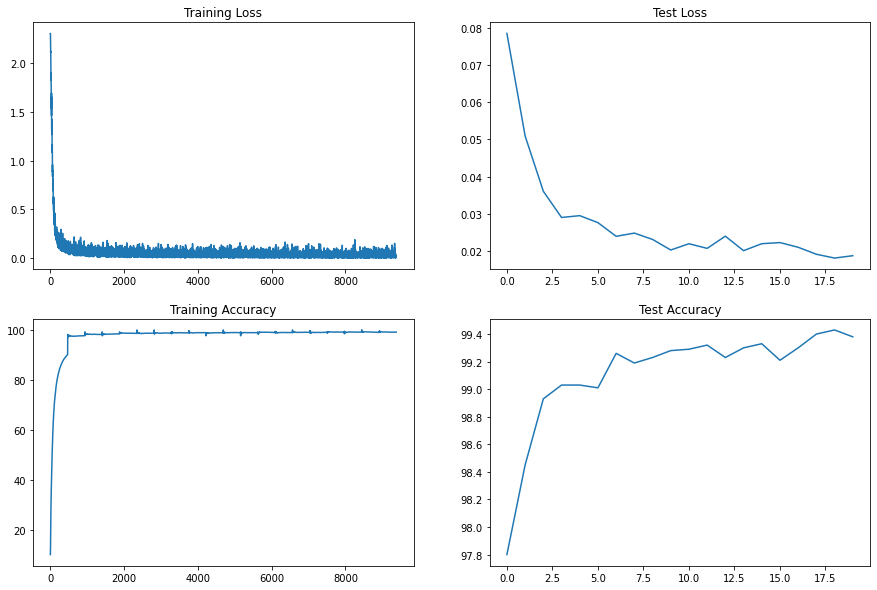

In [225]:
# Loss and accuracy curves for test and training 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

crosstab of incorrect prediction to understand patterns: 


Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,1,0,1,9,0,0
3,0,1,0,0,0,3,0,2,0,0
4,0,0,0,0,0,0,0,1,0,3
5,1,0,0,5,0,0,3,0,0,0
6,2,2,0,0,3,2,0,0,1,0
7,0,4,1,0,0,0,0,0,0,1
8,3,1,1,1,0,1,0,1,0,4


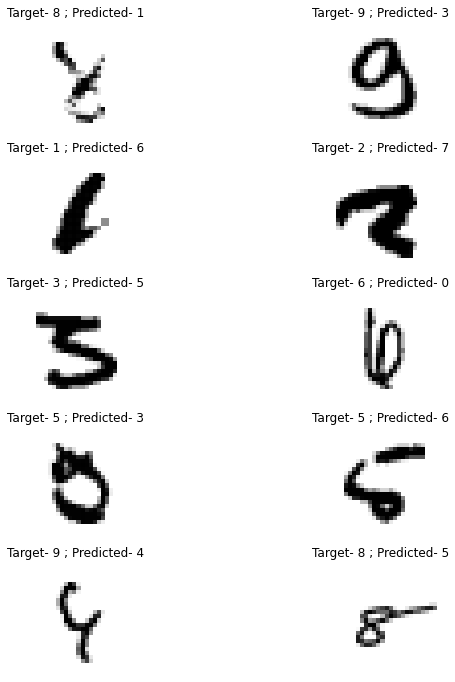

In [217]:
# model evaluation on misclassifications
model_eval_f(model, device, test_loader)

#### The above result is the pre-existing BN model from Assignment 4

## Experiment 1: Network with Group Normalization
Number of groups not given and taken as 4 (for no particular reason)

In [226]:
# Define model 1
model1 = model_py.NNet(dropout_val = 0.05, norm_type = 'GN').to(device)
summary(model1, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        GroupNorm-11            [-1, 8, 24, 24]              16
          Dropout-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

In [227]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
# model training running for 20 epochs on the skeleton
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # naive way of changing learning rate

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    training_f(model1, device, train_loader, optimizer, epoch)
    testing_f(model1, device, test_loader)

EPOCH: 0


Loss=0.18795549869537354 Batch_id=468 Accuracy=88.40: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]



Test set: Average loss: 0.0867, Accuracy: 9755/10000 (97.55%)

EPOCH: 1


Loss=0.059566035866737366 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]



Test set: Average loss: 0.0494, Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.15652433037757874 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]



Test set: Average loss: 0.0403, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.1124274805188179 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:19<00:00, 24.66it/s]



Test set: Average loss: 0.0364, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.021383099257946014 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]



Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.05205434933304787 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s]



Test set: Average loss: 0.0282, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.0117186876013875 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]



Test set: Average loss: 0.0251, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.00839162990450859 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s]



Test set: Average loss: 0.0288, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.038041435182094574 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]



Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.005658214446157217 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]



Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.003706910414621234 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0266, Accuracy: 9911/10000 (99.11%)

EPOCH: 11


Loss=0.007173736114054918 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]



Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.0038948317524045706 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 24.91it/s]



Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.01818353496491909 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 24.98it/s]



Test set: Average loss: 0.0248, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.025316262617707253 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]



Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.06358228623867035 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]



Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.03640491142868996 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]



Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.00613388093188405 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]



Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.01801205985248089 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 24.94it/s]



Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.08735918998718262 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]



Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)




Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

crosstab of incorrect prediction to understand patterns: 


Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,0,0,0,0,0,0,5,1,0,0
1,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,7,0,0
3,0,1,2,0,0,3,0,3,1,1
4,0,0,0,0,0,0,0,0,0,1
5,0,0,0,3,0,0,1,0,0,0
6,4,3,0,0,1,3,0,0,0,0
7,0,5,0,0,0,0,0,0,0,0
8,1,1,1,0,0,1,0,1,0,2


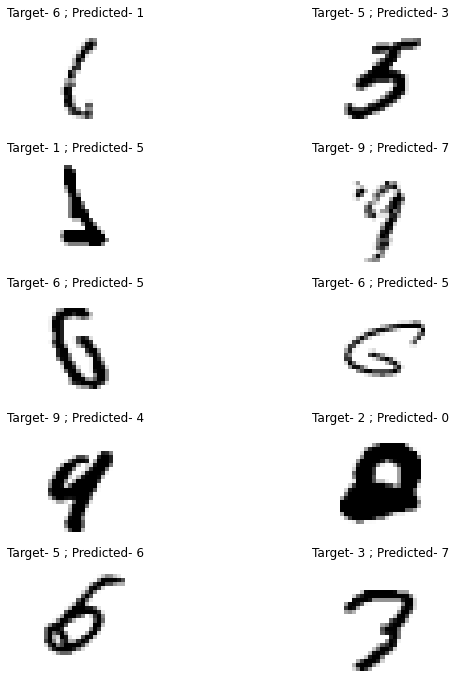

In [228]:
# model evaluation on misclassifications
model_eval_f(model1, device, test_loader)

In [229]:
metrics_m1 = [
    [t.cpu().item() for t in train_losses],
    test_losses,
    train_acc,
    test_acc
]

## Experiment 2: Network with Layer Normalization

In [242]:
# Define model 2
model2 = model_py.NNet(dropout_val = 0.05, norm_type = 'LN').to(device)
summary(model2, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        GroupNorm-11            [-1, 8, 24, 24]              16
          Dropout-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

In [243]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
# model training running for 20 epochs on the skeleton
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # naive way of changing learning rate

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    training_f(model2, device, train_loader, optimizer, epoch)
    testing_f(model2, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.06885574012994766 Batch_id=468 Accuracy=89.56: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s]



Test set: Average loss: 0.0763, Accuracy: 9780/10000 (97.80%)

EPOCH: 1


Loss=0.06600755453109741 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]



Test set: Average loss: 0.0395, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.040403056889772415 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]



Test set: Average loss: 0.0362, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.023264111950993538 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:18<00:00, 25.16it/s]



Test set: Average loss: 0.0357, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.018803944811224937 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]



Test set: Average loss: 0.0331, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.013619661331176758 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:18<00:00, 24.99it/s]



Test set: Average loss: 0.0332, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.02275954745709896 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]



Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.014260198920965195 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0276, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.01882399618625641 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]



Test set: Average loss: 0.0259, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.011292044073343277 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 24.85it/s]



Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.020161813125014305 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]



Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.019515959545969963 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]



Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.08990608900785446 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s]



Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.012457690201699734 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s]



Test set: Average loss: 0.0247, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.03899400681257248 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]



Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.08784618973731995 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.02872416190803051 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s]



Test set: Average loss: 0.0197, Accuracy: 9946/10000 (99.46%)

EPOCH: 17


Loss=0.02752630226314068 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 25.02it/s]



Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.010224255733191967 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]



Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.011311444453895092 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]



Test set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)




Test set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)

crosstab of incorrect prediction to understand patterns: 


Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,0,0,0,0,0,0,4,1,0,0
1,0,0,0,0,0,3,1,0,0,0
2,1,0,0,0,0,0,0,2,1,0
3,0,0,2,0,0,5,0,1,0,1
4,0,0,0,0,0,0,0,0,1,2
5,0,0,0,2,0,0,4,1,0,0
6,2,3,0,0,1,3,0,0,2,0
7,0,2,7,1,0,0,0,0,1,1
8,0,0,2,0,0,0,0,0,0,2


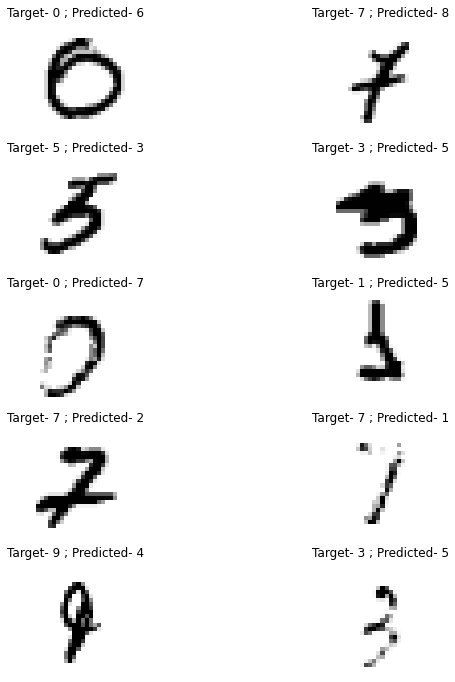

In [244]:
# model evaluation on misclassifications
model_eval_f(model2, device, test_loader)

In [245]:
metrics_m2 = [
    [t.cpu().item() for t in train_losses],
    test_losses,
    train_acc,
    test_acc
]

## Experiment 3: Network with L1 + BN
L1 taken as 0.001 (recommended over tutorials)
Modified the existing train() def and created train_L1()

In [247]:
# Define model 3
model3 = model_py.NNet(dropout_val = 0.05, norm_type = 'BN').to(device)
summary(model3, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
      BatchNorm2d-11            [-1, 8, 24, 24]              16
          Dropout-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

In [248]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
# model training running for 20 epochs on the skeleton
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # naive way of changing learning rate

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    training_L1_f(model3, device, train_loader, optimizer, epoch) # L1_norm based loss considered for training here
    testing_f(model3, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.17739082872867584 Batch_id=468 Accuracy=89.72: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]



Test set: Average loss: 0.0997, Accuracy: 9717/10000 (97.17%)

EPOCH: 1


Loss=0.11635974049568176 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]



Test set: Average loss: 0.0672, Accuracy: 9813/10000 (98.13%)

EPOCH: 2


Loss=0.13533248007297516 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]



Test set: Average loss: 0.0710, Accuracy: 9799/10000 (97.99%)

EPOCH: 3


Loss=0.10472146421670914 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:19<00:00, 23.72it/s]



Test set: Average loss: 0.0746, Accuracy: 9787/10000 (97.87%)

EPOCH: 4


Loss=0.06439365446567535 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]



Test set: Average loss: 0.0773, Accuracy: 9770/10000 (97.70%)

EPOCH: 5


Loss=0.07280240207910538 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:19<00:00, 23.58it/s]



Test set: Average loss: 0.0744, Accuracy: 9803/10000 (98.03%)

EPOCH: 6


Loss=0.28391334414482117 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:19<00:00, 23.60it/s]



Test set: Average loss: 0.0468, Accuracy: 9882/10000 (98.82%)

EPOCH: 7


Loss=0.08939117193222046 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]



Test set: Average loss: 0.0618, Accuracy: 9809/10000 (98.09%)

EPOCH: 8


Loss=0.052073314785957336 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]



Test set: Average loss: 0.0567, Accuracy: 9819/10000 (98.19%)

EPOCH: 9


Loss=0.05344575271010399 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0681, Accuracy: 9801/10000 (98.01%)

EPOCH: 10


Loss=0.0543682724237442 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:19<00:00, 23.79it/s]



Test set: Average loss: 0.0490, Accuracy: 9848/10000 (98.48%)

EPOCH: 11


Loss=0.1396918147802353 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:19<00:00, 23.61it/s]



Test set: Average loss: 0.0640, Accuracy: 9795/10000 (97.95%)

EPOCH: 12


Loss=0.03218497708439827 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]



Test set: Average loss: 0.0501, Accuracy: 9850/10000 (98.50%)

EPOCH: 13


Loss=0.031938839703798294 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]



Test set: Average loss: 0.0549, Accuracy: 9832/10000 (98.32%)

EPOCH: 14


Loss=0.06754031032323837 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]



Test set: Average loss: 0.0531, Accuracy: 9848/10000 (98.48%)

EPOCH: 15


Loss=0.06631258875131607 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:19<00:00, 23.74it/s]



Test set: Average loss: 0.0514, Accuracy: 9842/10000 (98.42%)

EPOCH: 16


Loss=0.031735703349113464 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:19<00:00, 23.78it/s]



Test set: Average loss: 0.0711, Accuracy: 9771/10000 (97.71%)

EPOCH: 17


Loss=0.10506710410118103 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:19<00:00, 24.15it/s]



Test set: Average loss: 0.0704, Accuracy: 9776/10000 (97.76%)

EPOCH: 18


Loss=0.1245485246181488 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:19<00:00, 23.92it/s]



Test set: Average loss: 0.0568, Accuracy: 9826/10000 (98.26%)

EPOCH: 19


Loss=0.10811251401901245 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:19<00:00, 23.92it/s]



Test set: Average loss: 0.0937, Accuracy: 9708/10000 (97.08%)




Test set: Average loss: 0.0937, Accuracy: 9708/10000 (97.08%)

crosstab of incorrect prediction to understand patterns: 


Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,0,0,0,0,4,0,1,1,0,7
1,0,0,3,0,0,1,1,0,0,0
2,1,7,0,0,12,0,0,19,2,0
3,0,0,2,0,0,0,0,3,1,0
5,0,3,0,24,0,0,6,1,3,1
6,7,6,2,0,18,1,0,0,2,2
7,0,66,1,0,5,0,0,0,0,0
8,0,3,2,0,0,0,1,1,0,6
9,0,8,0,2,55,1,0,0,0,0


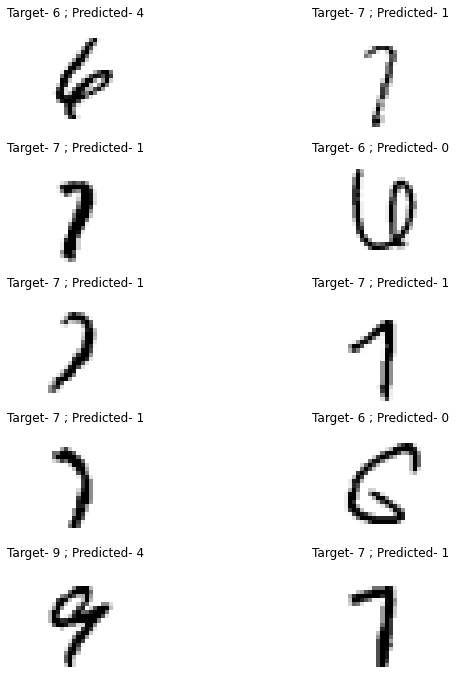

In [249]:
# model evaluation on misclassifications
model_eval_f(model3, device, test_loader)

In [250]:
metrics_m3 = [
    [t.cpu().item() for t in train_losses],
    test_losses,
    train_acc,
    test_acc
]

## Comparison of the 3 models on training/validation X loss/accuracy

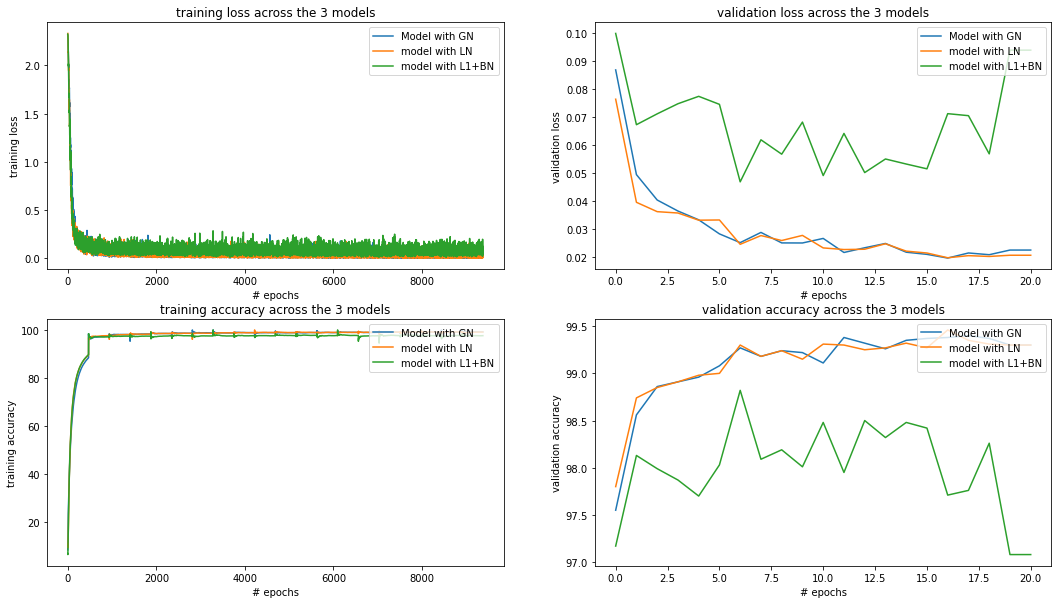

In [254]:
model_viz(metrics_m1, metrics_m2, metrics_m3)

Findings from the 3 experiments:
- Effect of GN: Similar to the original BN from last experiment BUT not better than that.The misclassifications are low and relatively spread out (0, 1, 4, 5, 7)

- Effect of LN: Slightly lower but comparable performance with GN. The misclassifications are slightly more and concentrated on specific numbers (7, 5, 2)

- Effect of static L1_Lambda based L1Norm + BN: Considerably worse validation performance with current fixed L1_lambda strategy. Lots of mispredictions for 1, 4, 3, 7

- of the 3 models, experiment with GN performs with the highest validation accuracy with very low degree of overfitting.

Misclassifications are majorly same across the 3 models and are primarily centered on predicting off versions of 7, 4, 5; 